In [28]:
import scipy.stats as sps
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from prometheus_client import samples

In [29]:
def generate_sample(N_range, distribution):
    samples = {}
    for N in N_range:
        sample = np.array(distribution.rvs(size=N))
        samples[N] = sample
    return samples


In [30]:
def calculate_interval_normal_expected_value(sample, confidence_probability):
    n = len(sample)
    accuracy = (sample.var() * sps.t((n - 1)).ppf((1 + confidence_probability) / 2)) / (n- 1)**0.5
    return [sample.mean() - accuracy, sample.mean() + accuracy]

In [31]:
def calculate_interval_normal_standard_deviation(sample, confidence_probability):
    n = len(sample)
    return [sample.var() * n**0.5 / (sps.chi2(n - 1).ppf((1 + confidence_probability) / 2))**0.5,
            sample.var() * n**0.5 / (sps.chi2(n - 1).ppf((1 - confidence_probability) / 2))**0.5]

In [32]:
def calculate_interval_expected_value(sample, confidence_probability):
    n = len(sample)
    accuracy = sample.var() * sps.norm.ppf((1 + confidence_probability) / 2) / n ** 0.5
    return [sample.mean() - accuracy, sample.mean() + accuracy]

In [33]:
def calculate_interval_standard_deviation(sample, confidence_probability):
    n = len(sample)
    return [
        sample.var() * (1 - (1 / (2 * n**0.5)) *  sps.norm.ppf((1 + confidence_probability) / 2) * (sps.kurtosis(sample) + 2)**0.5),
        sample.var() * (1 + (1 / (2 * n**0.5)) *  sps.norm.ppf((1 + confidence_probability) / 2) * (sps.kurtosis(sample) + 2)**0.5)
    ]

In [151]:
def calculate_normal_intervals(confidence_probability, samples):
    intervals = {}
    for N, sample in samples.items():
        intervals[N] =  (calculate_interval_normal_expected_value(sample, confidence_probability) +
                         calculate_interval_normal_standard_deviation(sample, confidence_probability))
    return intervals

In [152]:
def calculate_intervals(confidence_probability, samples):
    intervals = {}
    for N, sample in samples.items():
        intervals[N] =  (calculate_interval_expected_value(sample, confidence_probability) + 
                         calculate_interval_standard_deviation(sample, confidence_probability))
    return intervals

In [161]:
def plot_estimate_distribution_parameters(samples, intervals, distribution):
    fig, ax = plt.subplots(1, 4, figsize=(28, 8))
    for i, sample_item in enumerate(samples.items()):
        N, sample = sample_item
        sns.histplot(data=sample, bins= (int((max(sample) - min(sample)) / 5) + 1) * 5, stat='density', ax=ax[i], label=f"N(0, 1) hyst n = {N}")

        height_segments = 0.7
        ax[i].vlines(intervals[N][0], 0, height_segments, color='b', label='min \u03BC, max \u03BC')
        ax[i].plot(intervals[N][0], height_segments, 'bo')
        ax[i].vlines(intervals[N][1], 0, height_segments, color='b')
        ax[i].plot(intervals[N][1], height_segments, 'bo')

        ax[i].vlines(intervals[N][0] - intervals[N][3], 0, height_segments, color='r', label='min \u03BC - max\u03C3, max \u03BC + max\u03C3')
        ax[i].plot(intervals[N][0] - intervals[N][3], height_segments, 'ro')
        ax[i].vlines(intervals[N][1] + intervals[N][3], 0, height_segments, color='r')
        ax[i].plot(intervals[N][1] + intervals[N][3], height_segments, 'ro')

        ax[2].hlines(1 + (i + 1) / 10, intervals[N][0], intervals[N][1], color='b', linewidth=3, label=f'\u03BC interval n = {N}')
        ax[3].hlines(1 + (i + 1) / 10, intervals[N][0] - intervals[N][3], intervals[N][1] + intervals[N][3], color='r', linewidth=3, label=f'\u03C3 interval n = {N}')
    ax[2].set_ylim(1, 1.3)
    ax[3].set_ylim(1, 1.5)
    if distribution[1] == "Cauchy":
        ax[0].set_xscale("symlog")
        ax[1].set_xscale("symlog")
        ax[2].set_xscale("symlog")
        ax[3].set_xscale("symlog")
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')
    ax[2].legend(loc='upper right')
    ax[3].legend(loc='upper right')
    plt.savefig(f"{distribution[1]}_distribution")

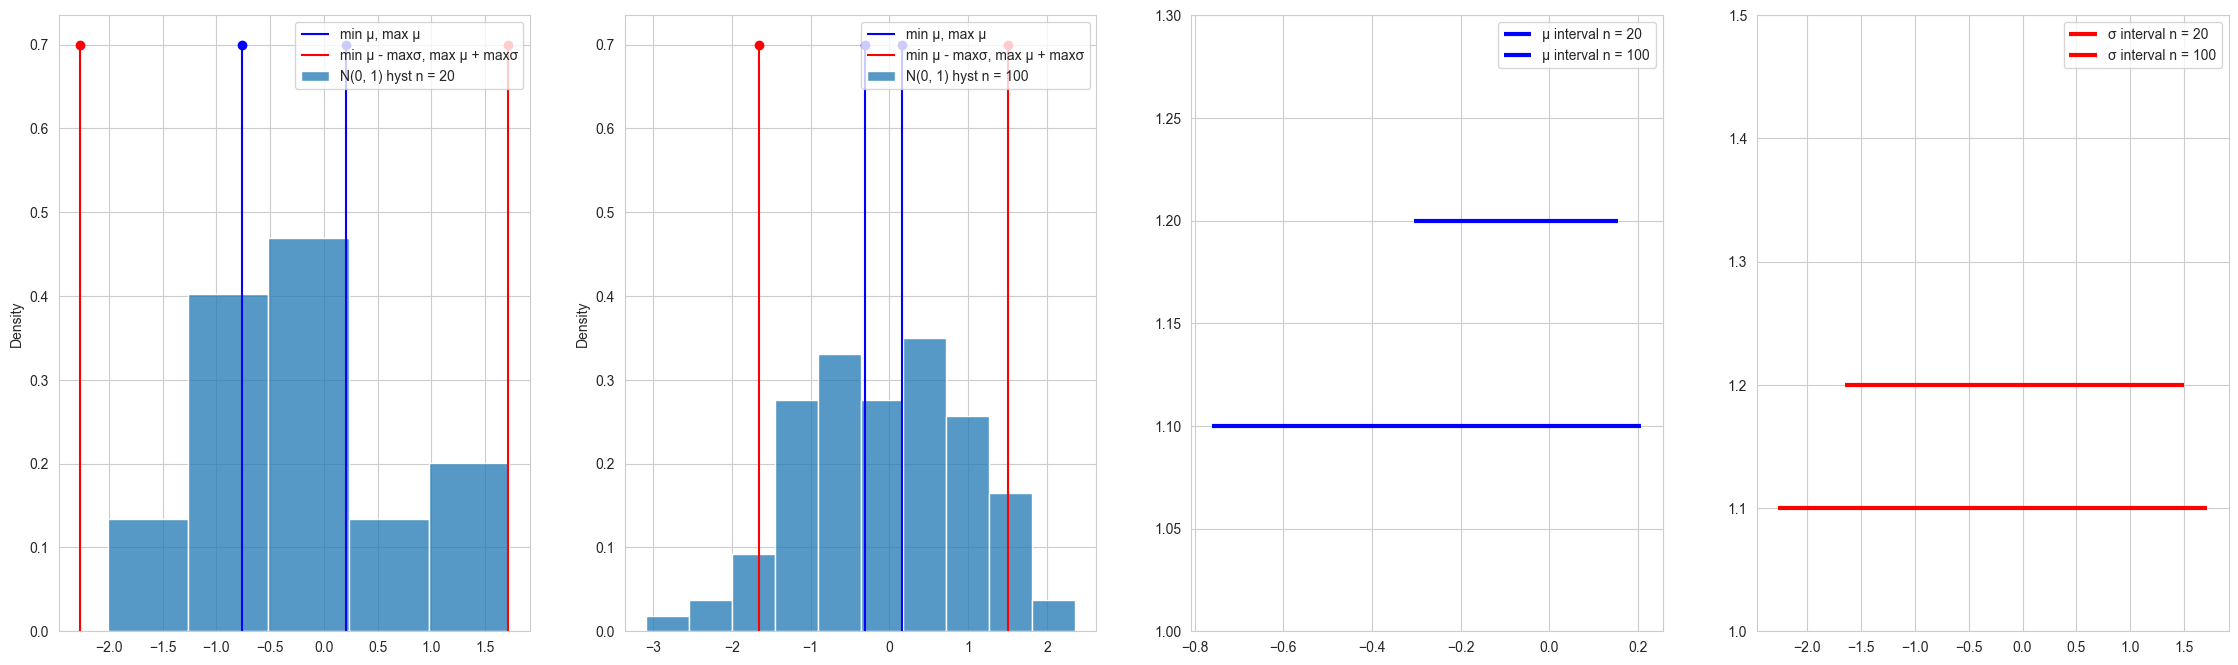

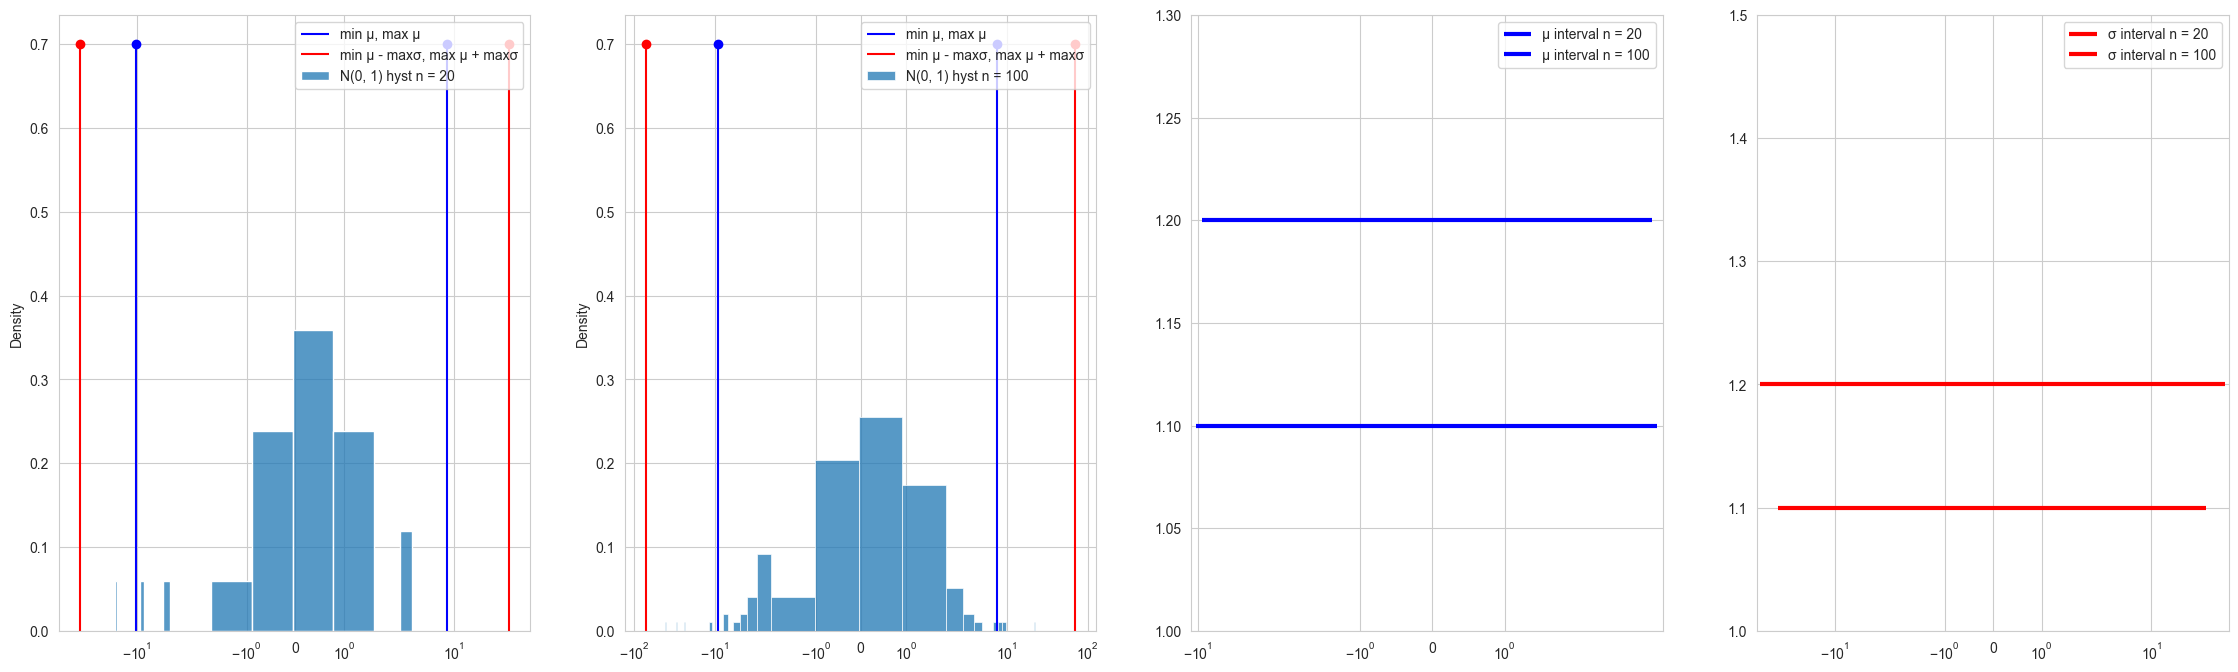

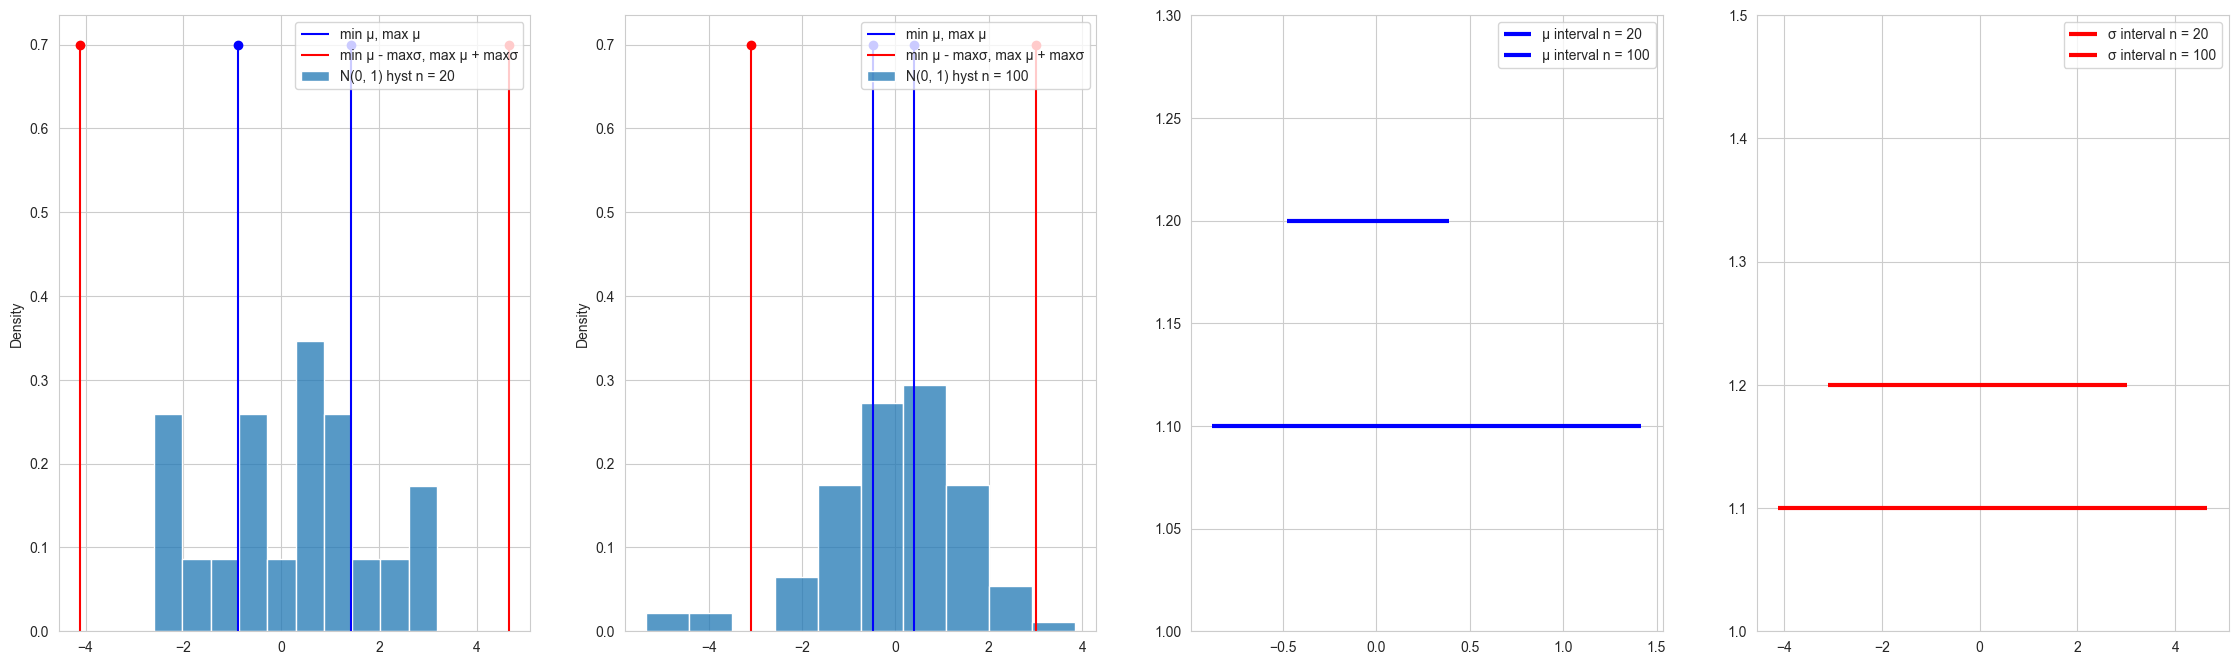

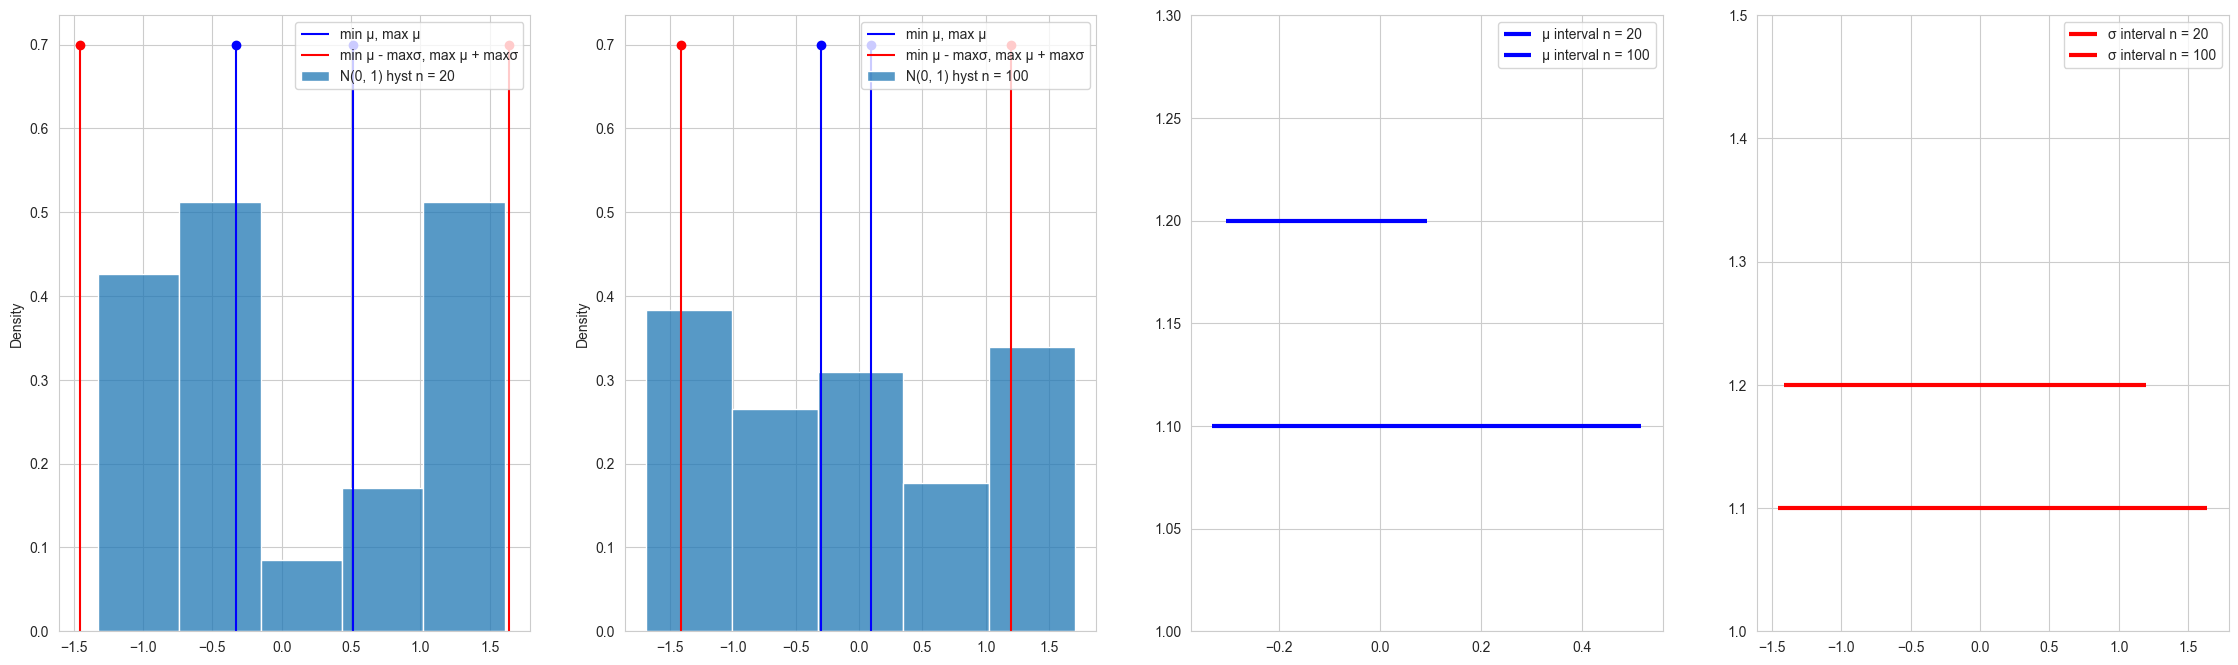

In [162]:
distributions = [[sps.norm, "Normal"],
                 [sps.cauchy, "Cauchy"],
                 [sps.t(3), "Student's"],
                 [sps.uniform(loc=-3**0.5, scale = 2 * 3**0.5), "Uniform"]
                ]
N_range = [20, 100]
confidence_probability = 0.95
for distribution in distributions:
    samples = generate_sample(N_range, distribution[0])
    if distribution[1] == "Normal":
        intervals = calculate_normal_intervals(confidence_probability, samples)
    else:
        intervals = calculate_intervals(confidence_probability, samples)
    plot_estimate_distribution_parameters(samples, intervals, distribution)